<div align="center">

# <span style="color: red;">Deep Learining (A.A. 2024-2025)</span>
### *Alberto Lazzeri*
## <span style="color: blue;">Pneumonia Detection using X-Ray images</span>
### *Deep Neural Network trained and evaluated for Pneumonia detection on children.*

</div>

## <span style="color: green;">Introduction</span>
The growing development of deep learning techniques has led in recent years to a significant expansion in their fields of application. Over the past 15 years, various artificial neural network models have been created and applied in the medical-clinical and pharmaceutical fields. In particular, within the clinical domain, the goal is to develop models capable of **performing diagnoses on patients** based on various types of data. This is done to provide support to physicians by automating the diagnostic process, which is often time-consuming and costly.

However, approaching this field comes with a number of challenges, the most relevant of which include:

- **Interpretability**: Deep learning models are often considered "black boxes" because it is difficult to understand how they arrive at their predictions. This is particularly critical in the medical context, where it is essential to understand the reasoning behind a diagnosis or clinical decision.
- **Dataset size and generalization**: Obtaining sufficiently large and representative medical datasets can be challenging. Moreover, models must generalize well to new data to be useful in clinical settings different from those they were trained on.
- **Reliability and safety**: It is crucial that models are reliable and safe. Even small errors or biases in the models can have serious consequences when it comes to medical diagnosis.
- **Clinical validation**: It is essential to conduct thorough clinical studies to validate the effectiveness of deep learning models before they can be adopted in clinical practice. This process requires significant time and resources.

In the paper called ["Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning"](./PIIS0092867418301545.pdf), submitted in 2017 and published in 2018 by [Cell](https://www.cell.com/cell/home), a group of Chinese and American researchers used **transfer learning** with a pre-trained model ([InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3)) to train an artificial neural network to recognize diabetic retinopathy from optical coherence tomography (OCT) images. They were able to achieve a more transparent and interpretable diagnosis by highlighting the regions of interest predicted by the model. Additionally, they applied the same model to the diagnosis of pneumonia in pediatric patients to evaluate its generalizability.

The aim of this project is to improve the results obtained in diagnosing pneumonia in pediatric patients by training two different models:

- Transfer learning with [DenseNet121](https://keras.io/api/applications/densenet/), recommended for medical images with small datasets  
- Transfer learning with [Xception](https://keras.io/api/applications/xception/), which typically offers higher accuracy

In [1]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from imagehash import average_hash

sns.set_style('darkgrid')

from PIL import Image
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, Xception 
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

2025-07-09 15:31:42.621936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 15:31:42.633796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 15:31:42.648159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 15:31:42.651768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 15:31:42.663272: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("--- GPU Availability Check (TensorFlow 2.x) ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow can access {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}")
else:
    print("TensorFlow cannot access a GPU. Running on CPU.")

--- GPU Availability Check (TensorFlow 2.x) ---
TensorFlow can access 1 GPU(s): ['/physical_device:GPU:0']


I0000 00:00:1752067904.586410    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752067904.620141    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752067904.620357    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## <span style="color: green;">Data visualization</span>
The dataset contains chest X-ray images of pediatric patients from the Guangzhou Women and Children’s Medical Center, located in Guangzhou. The dataset is available for download at [this link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). Data visualization and preprocessing methods were adapted from an existing work, which can be found [here](https://www.kaggle.com/code/despoinavoulgari/pneumonia-x-ray-images-rf-cnn-vgg16-98-4), which includes a well-structured data analysis, later improved based on the performance of previous models.

In order to make considerations on the dataset, extract the `zip` folder. In Ubuntu shell run:
```shell
unzip archive.zip
```
The unzipped folder should have this structure:
```text
chest_xray/
├── test/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── val/
    ├── NORMAL/
    └── PNEUMONIA/
```


The dataset is divided into three subsets: `train`, `validation`, and `test`. Each subfolder contains images of either healthy lungs (*NORMAL*) or lungs affected by pneumonia (*PNEUMONIA*).

In [3]:
base_dir = "chest_xray"

print(f"Proposed base_dir: {base_dir}")
print(f"Contents of proposed base_dir: {os.listdir(base_dir) if os.path.exists(base_dir) else 'Path does not exist.'}")

# Define the names of the subdirectories within base_dir
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

Proposed base_dir: chest_xray
Contents of proposed base_dir: ['test', 'train', 'val']


In [4]:
def count_images(directory):
    """Count images in directory and its subdirectories"""
    counts = defaultdict(int)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                class_name = os.path.basename(root)
                counts[class_name] += 1
    return dict(counts)

# Count images in each split
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Print results in a clear table format
table = [
    ["Train", train_counts.get('NORMAL', 0), train_counts.get('PNEUMONIA', 0), sum(train_counts.values())],
    ["Validation", val_counts.get('NORMAL', 0), val_counts.get('PNEUMONIA', 0), sum(val_counts.values())],
    ["Test", test_counts.get('NORMAL', 0), test_counts.get('PNEUMONIA', 0), sum(test_counts.values())],
    ["TOTAL", 
     train_counts.get('NORMAL', 0) + val_counts.get('NORMAL', 0) + test_counts.get('NORMAL', 0),
     train_counts.get('PNEUMONIA', 0) + val_counts.get('PNEUMONIA', 0) + test_counts.get('PNEUMONIA', 0),
     sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())]
]

print(tabulate(table, 
               headers=["Split", "NORMAL", "PNEUMONIA", "Total"], 
               tablefmt="grid",
               numalign="center"))

+------------+----------+-------------+---------+
| Split      |  NORMAL  |  PNEUMONIA  |  Total  |
+============+==========+=============+=========+
| Train      |   1341   |    3875     |  5216   |
+------------+----------+-------------+---------+
| Validation |    8     |      8      |   16    |
+------------+----------+-------------+---------+
| Test       |   234    |     390     |   624   |
+------------+----------+-------------+---------+
| TOTAL      |   1583   |    4273     |  5856   |
+------------+----------+-------------+---------+


### <span style="color: purple;">Dataset distribution analysis</span>
The dataset shows significant class imbalance and split distribution issues:

1. **Class Imbalance**: 
	- Pneumonia cases dominate (4,273) vs Normal (1,583)
2. **Split Problems**: 
	- Validation set is critically small (only 16 images): 8 Normal + 8 Pneumonia samples
	- Far below the recommended is 10-20% of total data
3. **Training Implications**:
	- The tiny validation set cannot provide reliable metrics
	- High risk of overfitting with no meaningful validation
	- Model performance claims will be statistically unreliable

### <span style="color: purple;">Redistribution splits</span>
Create a new directory (`data_redistributed_stratified`) with new split ratios: 70%, 15%, 15%.

In [5]:
# Define new split ratios (70-15-15)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

def redistribute_data_stratified(base_dir, new_base_dir):
    os.makedirs(new_base_dir, exist_ok=True)
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        # Collect all image paths
        class_path = os.path.join(base_dir, class_name)
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Generate labels (same length as images)
        labels = [class_name] * len(images)
        
        # First split: Train (70%) vs Temp (30%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            images, labels,
            test_size=(VAL_RATIO + TEST_RATIO),  # 30% for val+test
            stratify=labels,  # Critical for class balance
            random_state=42
        )
        
        # Second split: Val (15%) and Test (15%) from Temp
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=TEST_RATIO/(VAL_RATIO + TEST_RATIO),  # 0.15/0.3 = 0.5
            stratify=y_temp,  # Maintain balance in val/test
            random_state=42
        )
        
        # Copy files to new structure
        for split, paths in zip(['train', 'val', 'test'], [X_train, X_val, X_test]):
            dest_dir = os.path.join(new_base_dir, split, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            for src in tqdm(paths, desc=f'Copying {class_name} to {split}'):
                shutil.copy(src, dest_dir)

# Usage
redistribute_data_stratified(os.path.join(base_dir, 'train'), 'data_redistributed_stratified')

Copying PNEUMONIA to test: 100%|██████████| 582/582 [00:00<00:00, 8016.96it/s]


In [6]:
base_dir = 'data_redistributed_stratified'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# Get class distribution
def get_class_distribution(directory):
    classes = os.listdir(directory)
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len(os.listdir(class_path))
    return class_counts

train_dist = get_class_distribution(train_dir)
test_dist = get_class_distribution(test_dir)
val_dist = get_class_distribution(val_dir)

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Print results in a clear table format
table = [
    ["Train", train_counts.get('NORMAL', 0), train_counts.get('PNEUMONIA', 0), sum(train_counts.values())],
    ["Validation", val_counts.get('NORMAL', 0), val_counts.get('PNEUMONIA', 0), sum(val_counts.values())],
    ["Test", test_counts.get('NORMAL', 0), test_counts.get('PNEUMONIA', 0), sum(test_counts.values())],
    ["TOTAL", 
     train_counts.get('NORMAL', 0) + val_counts.get('NORMAL', 0) + test_counts.get('NORMAL', 0),
     train_counts.get('PNEUMONIA', 0) + val_counts.get('PNEUMONIA', 0) + test_counts.get('PNEUMONIA', 0),
     sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())]
]

print(tabulate(table, 
               headers=["Split", "NORMAL", "PNEUMONIA", "Total"], 
               tablefmt="grid",
               numalign="center"))

+------------+----------+-------------+---------+
| Split      |  NORMAL  |  PNEUMONIA  |  Total  |
+============+==========+=============+=========+
| Train      |   938    |    2712     |  3650   |
+------------+----------+-------------+---------+
| Validation |   201    |     581     |   782   |
+------------+----------+-------------+---------+
| Test       |   202    |     582     |   784   |
+------------+----------+-------------+---------+
| TOTAL      |   1341   |    3875     |  5216   |
+------------+----------+-------------+---------+


**After the redistribution we have:**

- **Class ratios are consistent**:
	- The distribution of PNEUMONIA (≈74%) vs. NORMAL (≈26%) is almost identical across training, test, and validation sets.
	- This prevents distribution mismatch, where the model performs well on training but poorly on test/validation.
- **Reasonable split sizes**: training set (~3650 samples) is the largest, which is good for learning. Test (~784) and validation (~782) sets are large enough for reliable evaluation.
- **Class Imbalance** (74% vs. 26%). Pneumonia cases dominate, which might bias the model toward predicting "PNEUMONIA" more often.
	- Solution: Use class weights (e.g., class_weight='balanced' in `scikit-learn`) or oversample the minority class (NORMAL).

Check now if there are **copies of the same image between sets**, because could cause overfitting cases across all models and lead to data leakage.

In [7]:
def get_image_hashes(directory):
    """Get hashes of all images in a directory and its subdirectories"""
    hashes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        hashes.append(average_hash(img))
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    return hashes

# Get hashes for all images
train_hashes = get_image_hashes(train_dir)
val_hashes = get_image_hashes(val_dir)
test_hashes = get_image_hashes(test_dir)

# Find duplicates
duplicates_tr_v = set(train_hashes) & set(val_hashes)
print(f"Number of duplicate images between train and validation found: {len(duplicates_tr_v)}")
duplicates_tr_t = set(train_hashes) & set(test_hashes)
print(f"Number of duplicate images between train and test found: {len(duplicates_tr_t)}")
duplicates_v_t = set(val_hashes) & set(test_hashes)
print(f"Number of duplicate images between validation and test found: {len(duplicates_v_t)}")

Number of duplicate images between train and validation found: 43
Number of duplicate images between train and test found: 51
Number of duplicate images between validation and test found: 15


**Results** show that:
- Train - Validation (43): model may "cheat" by memorizing validation samples
- Train - Test (51): test metrics become unreliable (false high accuracy)
- Validation - Test (15): reduces independence of evaluation sets

Data show problem of overlapping between the datasets. Identify these pictures throught **average hash** and preserve them to the `train` directory only.

In [8]:
duplicates_dir = os.path.join(base_dir, 'duplicates')
os.makedirs(duplicates_dir, exist_ok=True)

# This will store all unique hashes
unique_hashes = set()

# Process training set first (keep all training images)
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                h = str(average_hash(img))
                unique_hashes.add(h)
        except:
            continue

# Now process validation/test sets and move duplicates to train
for split_dir in [val_dir, test_dir]:
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(split_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    h = str(average_hash(img))
                    if h in unique_hashes:
                        # Move duplicate to train set
                        dest_dir = os.path.join(train_dir, class_name)
                        shutil.move(img_path, os.path.join(dest_dir, img_name))
                    else:
                        unique_hashes.add(h)
            except:
                continue

print("Duplicate removal complete!")

Duplicate removal complete!


In [9]:
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Print results in a clear table format
table = [
    ["Train", train_counts.get('NORMAL', 0), train_counts.get('PNEUMONIA', 0), sum(train_counts.values())],
    ["Validation", val_counts.get('NORMAL', 0), val_counts.get('PNEUMONIA', 0), sum(val_counts.values())],
    ["Test", test_counts.get('NORMAL', 0), test_counts.get('PNEUMONIA', 0), sum(test_counts.values())],
    ["TOTAL", 
     train_counts.get('NORMAL', 0) + val_counts.get('NORMAL', 0) + test_counts.get('NORMAL', 0),
     train_counts.get('PNEUMONIA', 0) + val_counts.get('PNEUMONIA', 0) + test_counts.get('PNEUMONIA', 0),
     sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())]
]

print(tabulate(table, 
               headers=["Split", "NORMAL", "PNEUMONIA", "Total"], 
               tablefmt="grid",
               numalign="center"))

+------------+----------+-------------+---------+
| Split      |  NORMAL  |  PNEUMONIA  |  Total  |
+============+==========+=============+=========+
| Train      |   985    |    2783     |  3768   |
+------------+----------+-------------+---------+
| Validation |   177    |     552     |   729   |
+------------+----------+-------------+---------+
| Test       |   179    |     540     |   719   |
+------------+----------+-------------+---------+
| TOTAL      |   1341   |    3875     |  5216   |
+------------+----------+-------------+---------+


### <span style="color: purple;">Image dimensions analysis</span>
Image pixels should be in gray scale with values within [0, 255] and not too large or small dimensions.

=== IMAGE STATISTICS ===
Train set:
  Average Pixel Value: 122.82 ± 18.43 (min: 60.69, max: 221.54)
  Width: 1320.16 ± 351.69 pixels
  Height: 965.64 ± 374.90 pixels

Validation set:
  Average Pixel Value: 123.19 ± 18.65 (min: 64.77, max: 201.84)
  Width: 1314.85 ± 358.23 pixels
  Height: 966.64 ± 380.79 pixels

Test set:
  Average Pixel Value: 123.64 ± 18.92 (min: 66.25, max: 185.11)
  Width: 1328.79 ± 370.42 pixels
  Height: 982.32 ± 396.55 pixels


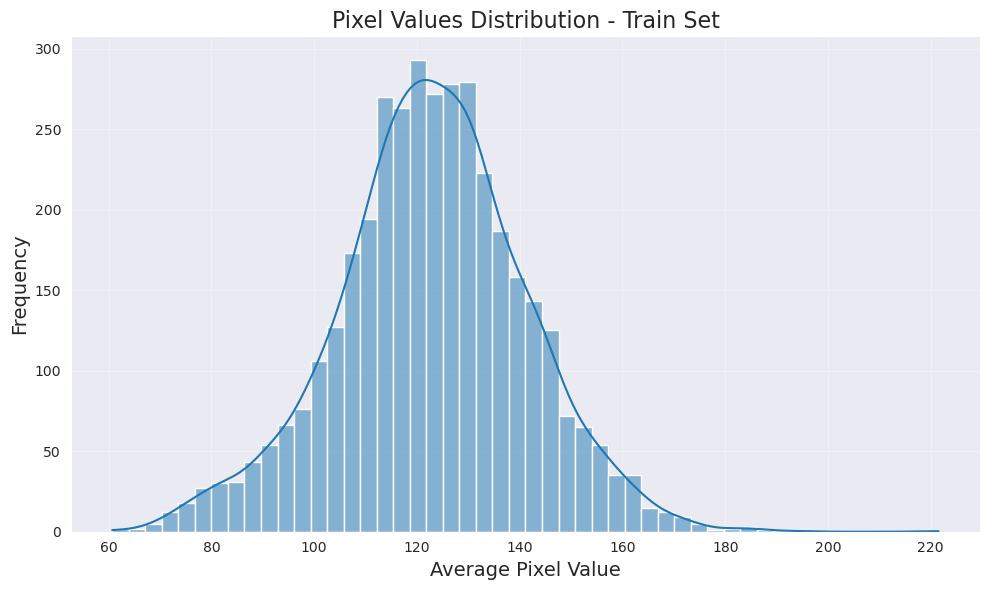

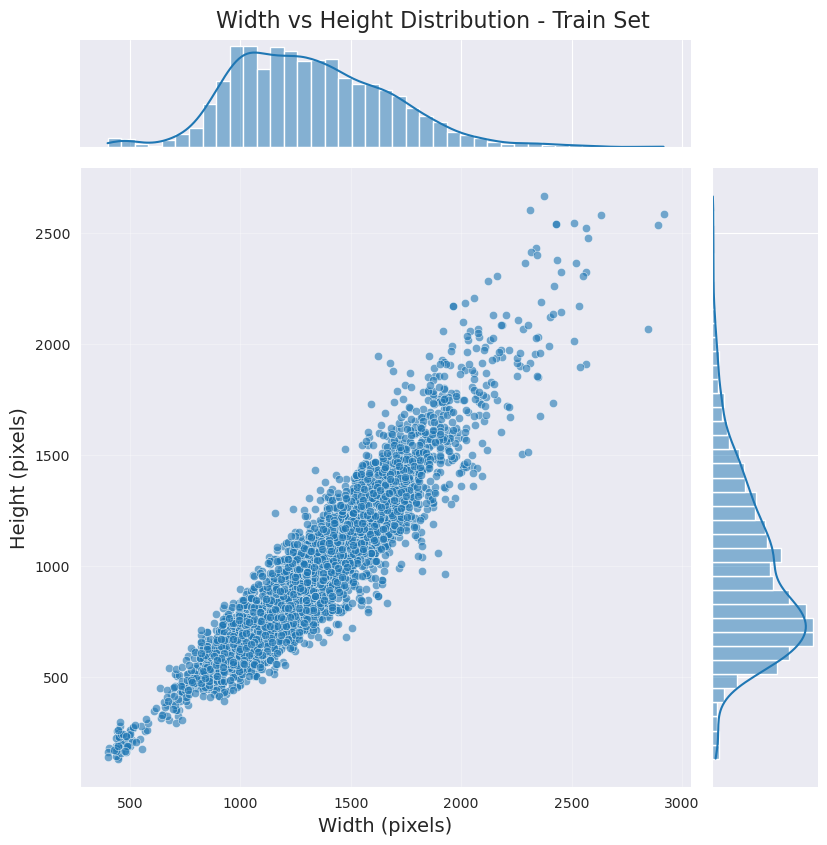

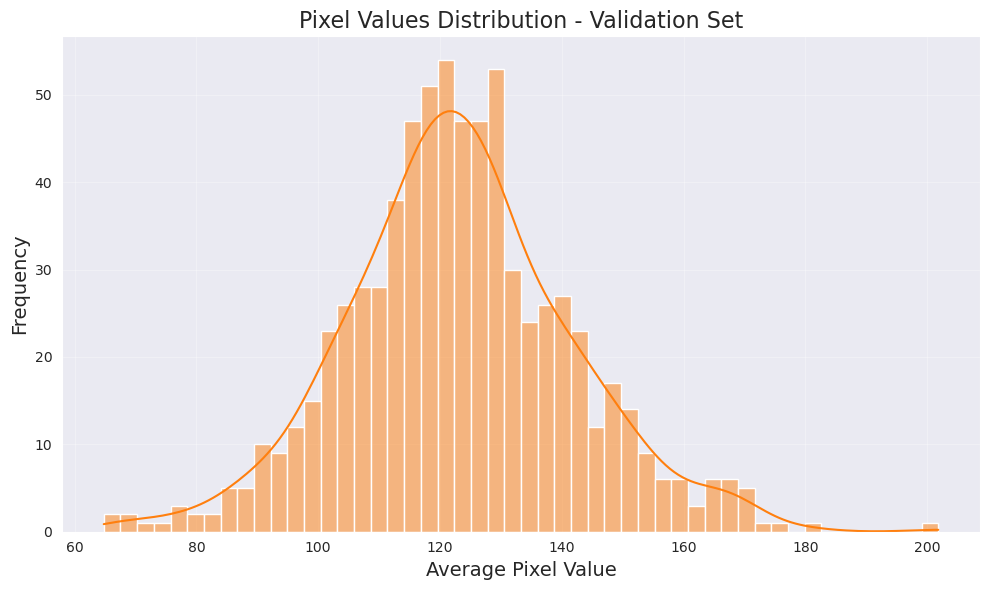

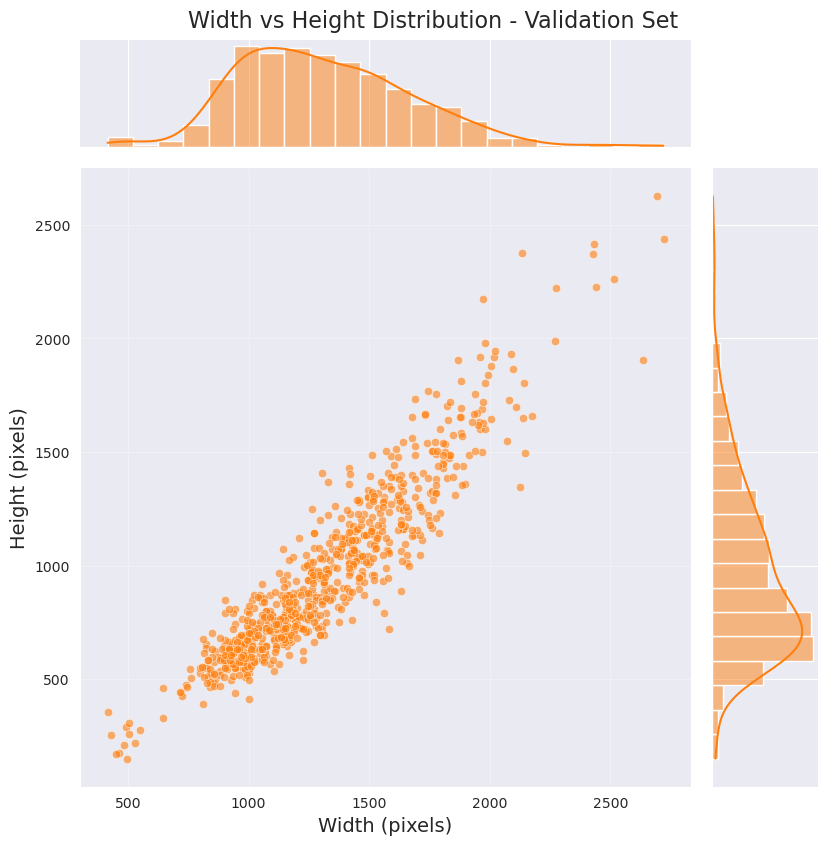

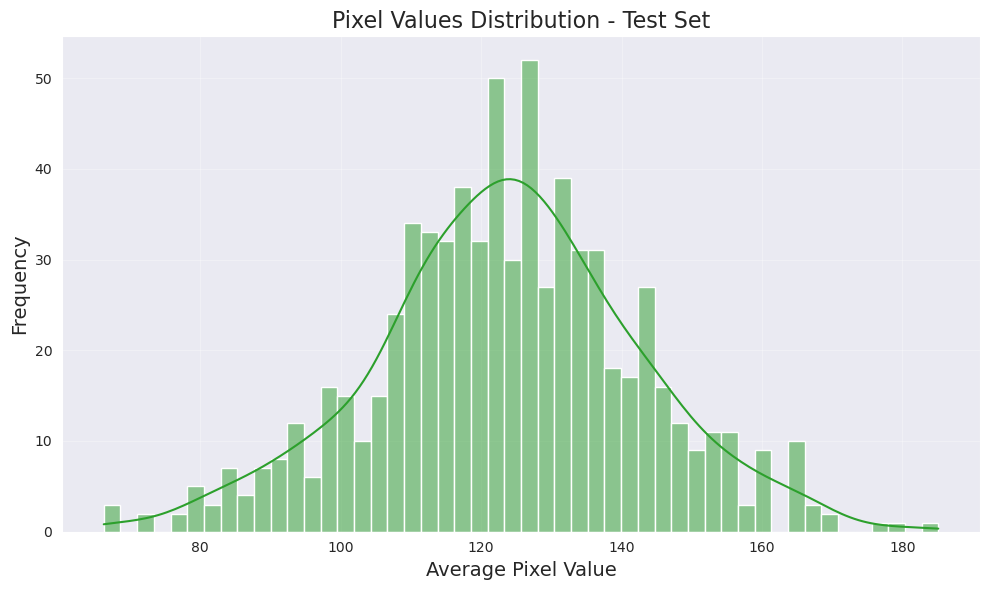

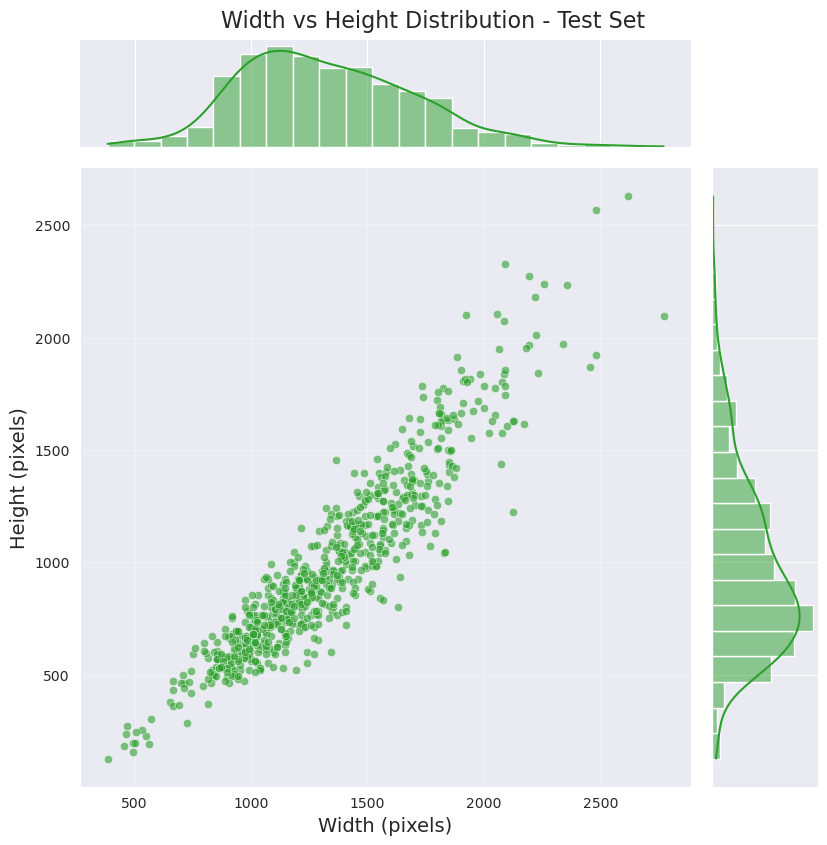

In [10]:
#calculate average pixel value, width and height with standard deviations
def calculate_average_image_dimensions(directory):
	pixel_values = []
	widths = []
	heights = []
	for root, _, files in os.walk(directory):
		for file in files:
			if file.lower().endswith(('.png', '.jpg', '.jpeg')):
				img_path = os.path.join(root, file)
				try:
					with Image.open(img_path) as img:
						# Convert to grayscale if needed and get pixel values
						if img.mode != 'L':
							img = img.convert('L')
						img_array = np.array(img)
						avg_pixel_value = np.mean(img_array)
						pixel_values.append(avg_pixel_value)
						
						# Get dimensions
						width, height = img.size
						widths.append(width)
						heights.append(height)
				except Exception as e:
					print(f"Error processing {img_path}: {str(e)}")
	
	if len(pixel_values) > 0:
		avg_pixel = np.mean(pixel_values)
		std_pixel = np.std(pixel_values)
		min_pixel = np.min(pixel_values)
		max_pixel = np.max(pixel_values)
		avg_width = np.mean(widths)
		std_width = np.std(widths)
		avg_height = np.mean(heights)
		std_height = np.std(heights)
		return avg_pixel, std_pixel, min_pixel, max_pixel, avg_width, std_width, avg_height, std_height
	else:
		return 0, 0, 0, 0, 0, 0, 0, 0

# Calculate dimensions for each split
train_stats = calculate_average_image_dimensions(train_dir)
val_stats = calculate_average_image_dimensions(val_dir)
test_stats = calculate_average_image_dimensions(test_dir)

print("=== IMAGE STATISTICS ===")
print(f"Train set:")
print(f"  Average Pixel Value: {train_stats[0]:.2f} ± {train_stats[1]:.2f} (min: {train_stats[2]:.2f}, max: {train_stats[3]:.2f})")
print(f"  Width: {train_stats[4]:.2f} ± {train_stats[5]:.2f} pixels")
print(f"  Height: {train_stats[6]:.2f} ± {train_stats[7]:.2f} pixels")
print()
print(f"Validation set:")
print(f"  Average Pixel Value: {val_stats[0]:.2f} ± {val_stats[1]:.2f} (min: {val_stats[2]:.2f}, max: {val_stats[3]:.2f})")
print(f"  Width: {val_stats[4]:.2f} ± {val_stats[5]:.2f} pixels")
print(f"  Height: {val_stats[6]:.2f} ± {val_stats[7]:.2f} pixels")
print()
print(f"Test set:")
print(f"  Average Pixel Value: {test_stats[0]:.2f} ± {test_stats[1]:.2f} (min: {test_stats[2]:.2f}, max: {test_stats[3]:.2f})")
print(f"  Width: {test_stats[4]:.2f} ± {test_stats[5]:.2f} pixels")
print(f"  Height: {test_stats[6]:.2f} ± {test_stats[7]:.2f} pixels")

#plot distribution of pixel values and image dimensions
def plot_image_size_distribution(directory, title):
	pixel_values = []
	widths = []
	heights = []
	for root, _, files in os.walk(directory):
		for file in files:
			if file.lower().endswith(('.png', '.jpg', '.jpeg')):
				img_path = os.path.join(root, file)
				try:
					with Image.open(img_path) as img:
						# Convert to grayscale and get pixel values
						if img.mode != 'L':
							img = img.convert('L')
						img_array = np.array(img)
						avg_pixel_value = np.mean(img_array)
						pixel_values.append(avg_pixel_value)
						
						# Get dimensions
						width, height = img.size
						widths.append(width)
						heights.append(height)
				except Exception as e:
					print(f"Error processing {img_path}: {str(e)}")
	
	# Define colors for different sets
	if "Train" in title:
		color = '#1f77b4'  # Blue
	elif "Validation" in title:
		color = '#ff7f0e'  # Orange
	elif "Test" in title:
		color = '#2ca02c'  # Green
	else:
		color = '#d62728'  # Red (default)
	
	# Create two separate figures
	# Figure 1: Histogram of pixel values
	plt.figure(figsize=(10, 6))
	sns.histplot(pixel_values, bins=50, kde=True, color=color)
	plt.title(f"Pixel Values Distribution - {title}", fontsize=16)
	plt.xlabel("Average Pixel Value", fontsize=14)
	plt.ylabel("Frequency", fontsize=14)
	plt.grid(True, alpha=0.3)
	plt.tight_layout()
	plt.show()
	
	# Figure 2: Scatter plot with marginal distributions
	g = sns.JointGrid(x=widths, y=heights, height=8, ratio=5)
	g.plot_joint(sns.scatterplot, alpha=0.6, color=color)
	g.plot_marginals(sns.histplot, kde=True, color=color)
	g.set_axis_labels("Width (pixels)", "Height (pixels)", fontsize=14)
	g.fig.suptitle(f"Width vs Height Distribution - {title}", y=1.02, fontsize=16)
	g.ax_joint.grid(True, alpha=0.3)
	plt.show()

plot_image_size_distribution(train_dir, "Train Set")
plot_image_size_distribution(val_dir, "Validation Set")
plot_image_size_distribution(test_dir, "Test Set")


**Results**:
1. Pixel values:
	- they are within 0-255 interval in gray scale, which is correct normalization
	- Mean value (for train set, similiar for validation and test) is $\mu = 122.82$ and std dev is $\sigma = 18.43$, which gives a balanced distribution since $\frac{255-0}{2} - \sigma \leq \mu \leq \frac{255-0}{2}+\sigma$
2. Average image size
	- is 1320 (width) and 965 (heigth), for train set, but test and validation values are similar
	- Image dimensions are large, which give high resolution and details.
	- However image dimensions will be fixed before training.

### <span style="color: purple;">Image quality analysis</span>
An image quality check now should be done in order to avoid bias or dataset inconsistency. Images should be in gray scale and not in RGB or others. Previous work showed that color discrepancy correlates with label errors.

In [11]:
def check_image_quality(directory):
    problematic = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_file in os.listdir(class_path):
            try:
                img = Image.open(os.path.join(class_path, img_file))
                img.verify()  # Verify integrity
                if img.mode != 'L':  # Check if grayscale
                    problematic.append((class_name, img_file, 'Color mode issue'))
            except Exception as e:
                problematic.append((class_name, img_file, str(e)))
    
    return pd.DataFrame(problematic, columns=['Class', 'Filename', 'Issue'])

quality_issues = check_image_quality(train_dir)
if not quality_issues.empty:
    print("Found image quality issues in train set:")
    display(quality_issues)
else:
    print("No image quality issues detected for train set")
    
quality_issues_val = check_image_quality(val_dir)
if not quality_issues_val.empty:
    print("Found image quality issues in validation set:")
    display(quality_issues_val)
else:
    print("No image quality issues detected for validation set")

quality_issues_test = check_image_quality(test_dir)
if not quality_issues_test.empty:
	print("Found image quality issues in test set:")
	display(quality_issues_test)
else:
	print("No image quality issues detected for test set")

Found image quality issues in train set:


,Class,Filename,Issue
0,PNEUMONIA,person905_bacteria_2830.jpeg,Color mode issue
1,PNEUMONIA,person1644_bacteria_4361.jpeg,Color mode issue
2,PNEUMONIA,person940_virus_1609.jpeg,Color mode issue
3,PNEUMONIA,person421_virus_866.jpeg,Color mode issue
4,PNEUMONIA,person894_bacteria_2819.jpeg,Color mode issue
...,...,...,...
196,PNEUMONIA,person1670_bacteria_4426.jpeg,Color mode issue
197,PNEUMONIA,person347_bacteria_1599.jpeg,Color mode issue
198,PNEUMONIA,person306_virus_628.jpeg,Color mode issue
199,PNEUMONIA,person1197_virus_2039.jpeg,Color mode issue


Found image quality issues in validation set:


,Class,Filename,Issue
0,PNEUMONIA,person630_virus_1209.jpeg,Color mode issue
1,PNEUMONIA,person1170_virus_1969.jpeg,Color mode issue
2,PNEUMONIA,person1131_bacteria_3073.jpeg,Color mode issue
3,PNEUMONIA,person528_bacteria_2227.jpeg,Color mode issue
4,PNEUMONIA,person1133_virus_1865.jpeg,Color mode issue
5,PNEUMONIA,person663_virus_1247.jpeg,Color mode issue
6,PNEUMONIA,person819_virus_1455.jpeg,Color mode issue
7,PNEUMONIA,person1186_virus_2021.jpeg,Color mode issue
8,PNEUMONIA,person282_virus_579.jpeg,Color mode issue
9,PNEUMONIA,person734_virus_1355.jpeg,Color mode issue


Found image quality issues in test set:


,Class,Filename,Issue
0,PNEUMONIA,person430_virus_879.jpeg,Color mode issue
1,PNEUMONIA,person466_bacteria_1984.jpeg,Color mode issue
2,PNEUMONIA,person309_virus_631.jpeg,Color mode issue
3,PNEUMONIA,person407_virus_811.jpeg,Color mode issue
4,PNEUMONIA,person1177_virus_2001.jpeg,Color mode issue
5,PNEUMONIA,person1220_virus_2068.jpeg,Color mode issue
6,PNEUMONIA,person1308_bacteria_3280.jpeg,Color mode issue
7,PNEUMONIA,person1263_bacteria_3221.jpeg,Color mode issue
8,PNEUMONIA,person508_virus_1020.jpeg,Color mode issue
9,PNEUMONIA,person1642_bacteria_4352.jpeg,Color mode issue


**Results**:
1. All problematic images are from the same class: Pneumonia
	- This suggests a systematic data collection or processing artifact

However this images will be kept, otherwise dataset will be even smaller. Here there are some examples between a Issued image and a standard image.

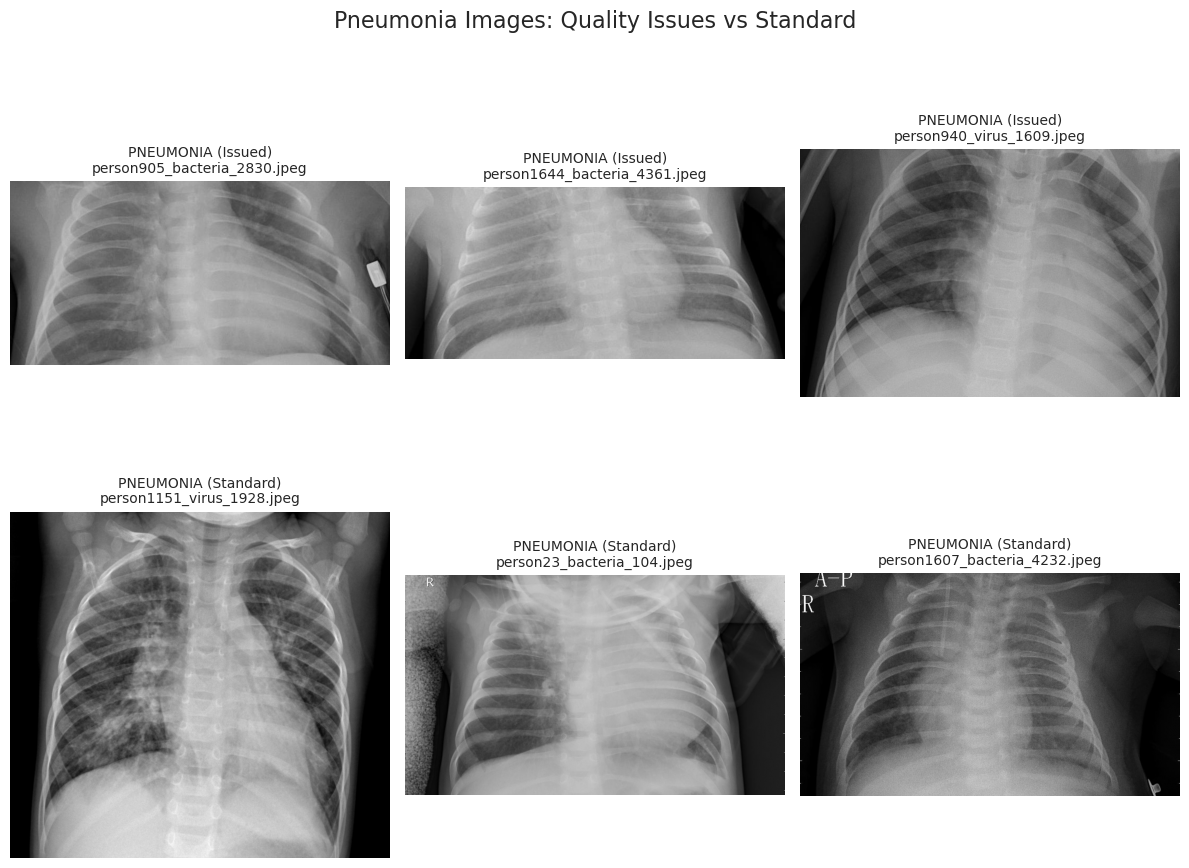

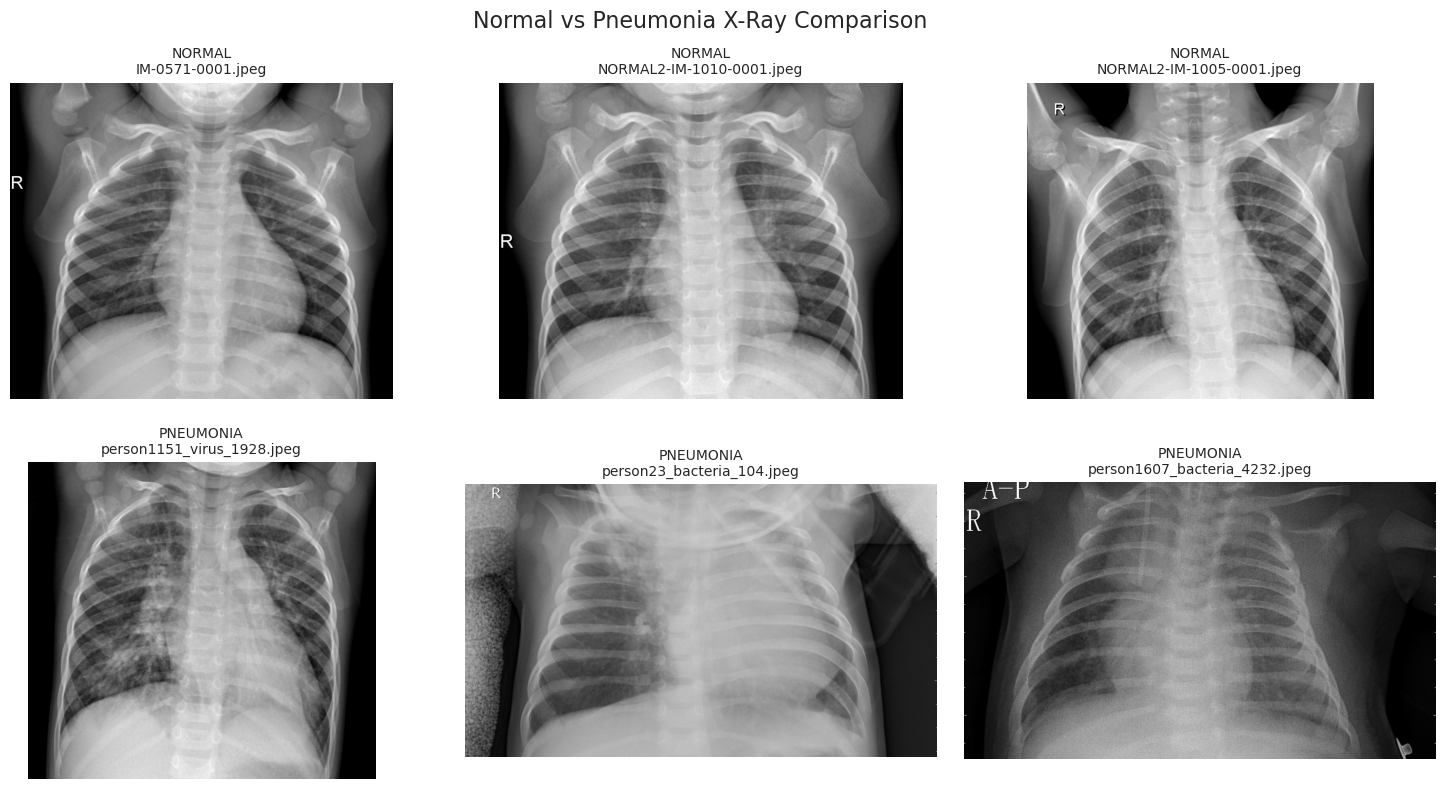

In [12]:
# Plot comparison between issued and non-issued pneumonia images
def plot_pneumonia_quality_comparison(directory):
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    all_images = os.listdir(pneumonia_path)
    issued_images = []
    non_issued_images = []
    for img_file in all_images:
        try:
            img_path = os.path.join(pneumonia_path, img_file)
            img = Image.open(img_path)
            if img.mode != 'L':
                issued_images.append(img_file)
            else:
                non_issued_images.append(img_file)
        except:
            continue
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))    
    # Plot issued pneumonia images
    for i in range(3):
        if i < len(issued_images):
            img_path = os.path.join(pneumonia_path, issued_images[i])
            img = Image.open(img_path)
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f"PNEUMONIA (Issued)\n{issued_images[i]}", fontsize=10)
            axes[0, i].axis('off')
    
    # Plot non-issued pneumonia images
    for i in range(3):
        if i < len(non_issued_images):
            img_path = os.path.join(pneumonia_path, non_issued_images[i])
            img = Image.open(img_path)
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f"PNEUMONIA (Standard)\n{non_issued_images[i]}", fontsize=10)
            axes[1, i].axis('off')
    
    plt.suptitle("Pneumonia Images: Quality Issues vs Standard", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Plot comparison between normal and pneumonia classes
def plot_class_comparison(directory, num_images=3):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 8))
    
    for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)[:num_images]
        
        for j, img_file in enumerate(images):
            ax = axes[i,j]
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{class_name}\n{img_file}", fontsize=10)
            ax.axis('off')
    
    plt.suptitle("Normal vs Pneumonia X-Ray Comparison", fontsize=16, y=0.98)
    plt.tight_layout(h_pad=2.0, w_pad=2.0)  # Vertical and horizontal padding
    plt.show()

# Execute the plots
plot_pneumonia_quality_comparison(train_dir)
plot_class_comparison(train_dir)

## <span style="color: green;">Transfer learning</span>
**Transfer learning** is a machine learning technique where a model developed for a specific task is reused as the starting point for a model on a second, related task. In deep learning, it typically involves **taking a pre-trained model**, usually trained on a large dataset like ImageNet, and fine-tuning it on a smaller, task-specific dataset.

This approach is especially useful when labeled data is limited, as in this case. It allows the model to leverage learned features (such as edges, textures, or shapes) from the original training task, **improving performance and reducing training time**.

In the past years some pre-trained models for image classification (and similar tasks) were developed (from Google, Facebook, Keras and others...) and trained on large dataset from [ImageNet](https://www.image-net.org/).

All of these models are based on Convolutional Neural Networks (CNNs) and differ in terms of:

- **Core structure** (e.g., linear, modular, etc.) and **architectural complexity** (e.g., number of layers, number of parameters, etc.)
- **Efficiency and speed**
- **Accuracy and generalization capabilities**

The choice of the most suitable pre-trained model for a specific problem depends on several factors. In this case, the most important are:

1. A reduced number of parameters and low RAM/GPU usage  
2. A good trade-off between accuracy and efficiency  
3. Strong performance on high-resolution grayscale medical images  

The [Keras 3 API Applications page](https://keras.io/api/applications/) includes the most widely used pre-trained models and provides easy access to them.


### <span style="color: purple;">DenseNet121</span>

DenseNet121 ([*Densely Connected Convolutional Networks*](https://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html), Huang et al., 2017) is one of the most effective CNNs developed so far. It is based on the idea that **all feature maps produced by previous layers are passed to subsequent layers**, and are processed as a sequence (rather than being summed, as in ResNet, for example), instead of only forwarding the output of the immediate previous layer.

A *feature map* is the intermediate representation of an image obtained after applying a convolutional filter in a CNN — essentially a transformed version of the image that reflects "what the network has learned to recognize" at a specific depth. Feature maps can be extracted during model training at any chosen depth level.

In traditional CNNs, the input of the $l$-th layer depends on the previous one as follows:  
$$x_l = H_l(x_{l-1})$$

In DenseNet, the formulation becomes:  
$$x_l = H_l([x_0, x_1, ..., x_{l-1}])$$  
where $[x_0, x_1, ..., x_{l-1}]$ are the feature maps from all preceding layers.

In DenseNet, $H_l(\cdot)$ is a composite function consisting of three steps:
1. Batch Normalization (BN)  
2. Rectified Linear Unit activation (ReLU)  
3. 3×3 Convolution (Conv.)

**DenseNet121 is composed of 4 Dense Blocks**, separated by convolutional and average pooling layers. Each layer within a block is structured as:  
`BN → ReLU → 1×1 Conv (bottleneck) → BN → ReLU → 3×3 Conv`.  
The overall architecture consists of:

1. **Initial convolution** (7×7 Conv, stride 2 + MaxPooling)  
2. **Dense Block 1** (6 layers)  
3. **Transition 1** (1×1 Conv + 2×2 Average Pooling)  
4. **Dense Block 2** (12 layers)  
5. **Transition 2** (1×1 Conv + Average Pooling)  
6. **Dense Block 3** (24 layers)  
7. **Transition 3** (1×1 Conv + Average Pooling)  
8. **Dense Block 4** (16 layers)  
9. **Classification** (Global Average Pooling + Dense Softmax)

DenseNet121 is a very **deep network with relatively few parameters (~8 million)**, which makes it **efficient, fast, and memory-friendly**. It is widely used in **medical imaging**, and adapts well to the type of dataset used in this project. It is estimated to achieve a **Top-1 Accuracy of 75.0%**, making it an excellent compromise between high accuracy and computational efficiency.


### <span style="color: purple;">Data generation and augmentation</span>
Since DenseNet121 expects 3-channel input images (e.g., RGB), two additional channels are added by duplicating the grayscale channel into all three channels.

All images are resized to a default dimension of **320×320 pixels** to ensure uniform input size and to keep computational costs manageable.

Each pixel value is **normalized** by dividing by 255.

For **data augmentation**, the following transformations are applied:

- **Rotation** (range = ±10 degrees)  
- **Translation** (up to 5%)  
- **Zoom** (up to 5%)  
- **Brightness adjustment** (±5%)  
- **Horizontal flip**  
- **Fill mode**: *nearest*


In [13]:
# --- CONFIG --- WITH CLASS WEIGHTING ---
IMG_WIDTH = 320
IMG_HEIGHT = 320
BATCH_SIZE = 32

AUTOTUNE = tf.data.AUTOTUNE

# --- Dataset di base ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',  # 0 e 1
    color_mode='grayscale',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

def grayscale_to_rgb_gen(gen):
    for x_batch, y_batch in gen:
        x_rgb = np.repeat(x_batch, 3, axis=-1)
        yield x_rgb, y_batch
        
def preprocess(img, label):
    img = tf.image.grayscale_to_rgb(img)        # da (H,W,1) a (H,W,3)
    img = tf.cast(img, tf.float32) / 255.0       # normalizzazione
    return img, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomBrightness(0.05),
    tf.keras.layers.RandomFlip('horizontal')
])

def augment(img, label):
    img = data_augmentation(img)
    return img, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

y_train = np.concatenate([y.numpy().flatten() for _, y in train_ds])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Found 3768 files belonging to 2 classes.


I0000 00:00:1752068227.970259    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752068227.970522    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752068227.970674    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752068228.035720    7682 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 729 files belonging to 2 classes.
Found 719 files belonging to 2 classes.


2025-07-09 15:37:19.904121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 34 of 1000
2025-07-09 15:37:30.121125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 64 of 1000
2025-07-09 15:37:49.955482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 108 of 1000


Class weights: {0: 1.9126903553299492, 1: 0.6769673014732304}


2025-07-09 15:37:53.539096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-07-09 15:37:53.564435: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### <span style="color: purple;">Model architecture and training setup</span>

The model used for this task consists of:

- A **DenseNet121** backbone pre-trained on ImageNet  
- **Global Average Pooling**, to reduce the feature maps to a single dimension  
- A **Fully Connected layer** with 128 neurons and ReLU activation function  
- **Batch Normalization**, to accelerate training and improve stability  
- **Dropout**, to prevent overfitting  
- A final **binary classification layer** with **sigmoid** activation

The optimizer used is **Adam** (*Adaptive Moment Estimation*), which updates the learning rate dynamically for each parameter using both the first moment (mean) and second moment (variance) of the gradients.

The loss function is **Binary Crossentropy (BCE)**, a variant of Crossentropy used for binary classification tasks. The evaluation metric is **accuracy**.

The following **callbacks** were used during training:

- **Early Stopping**: Monitors the validation loss and stops training if it does not improve for 5 consecutive epochs.  
- **Model Checkpoint**: Saves the model weights at each epoch where the validation loss improves. At the end, the best model (based on validation loss) is retained.  
- **Learning Rate Scheduler**: Reduces the learning rate by a factor of 0.75 if the validation loss does not improve for 2 epochs, down to a minimum of $10^{-6}$. This helps ensure faster and more stable convergence.


In [14]:
DenseNet_base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

DenseNet_base_model.trainable = False  # Freeze the base model

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = DenseNet_base_model(inputs, training=False)  # Freeze backbone
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

DenseNet_model = Model(inputs=inputs, outputs=outputs)

DenseNet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('DenseNet121_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)
] 

DenseNet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 10, 10, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,345 (27.35 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 7,037,760 (26.85 MB)

In [15]:
print("\n--- Starting DenseNet121 Model Training ---")
history = DenseNet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)
#save loss and accuracy in a npy file
np.save('DenseNet121_history.npy', {
	'loss': history.history['loss'],
	'val_loss': history.history['val_loss'],
	'accuracy': history.history['accuracy'],
	'val_accuracy': history.history['val_accuracy']
})
print("--- DenseNet121 Model Training Finished ---")


--- Starting DenseNet121 Model Training ---
Epoch 1/20


I0000 00:00:1752068315.109935    7875 service.cc:146] XLA service 0x7ff18001afe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752068315.109993    7875 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2025-07-09 15:38:35.454387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-09 15:38:37.673353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-07-09 15:38:41.553446: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,320,320]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_q

102/118 ━━━━━━━━━━━━━━━━━━━━ 12s 760ms/step - accuracy: 0.5113 - loss: 0.8584

2025-07-09 15:41:10.652995: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[24,64,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,320,320]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-09 15:41:11.296266: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.64338261s
Trying algorithm eng0{} for conv (f32[24,64,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,320,320]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5179 - loss: 0.8475

2025-07-09 15:42:53.895928: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[25,64,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,320,320]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-09 15:42:54.607298: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.71144216s
Trying algorithm eng0{} for conv (f32[25,64,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,320,320]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait


Epoch 1: val_loss improved from inf to 0.61414, saving model to DenseNet121_best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5183 - loss: 0.8469 - val_accuracy: 0.6722 - val_loss: 0.6141 - learning_rate: 1.0000e-04
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.6167 - loss: 0.6406
Epoch 2: val_loss improved from 0.61414 to 0.39389, saving model to DenseNet121_best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 923ms/step - accuracy: 0.6166 - loss: 0.6405 - val_accuracy: 0.8546 - val_loss: 0.3939 - learning_rate: 1.0000e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.6195 - loss: 0.5926
Epoch 3: val_loss improved from 0.39389 to 0.37911, saving model to DenseNet121_best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 110s 930ms/step - accuracy: 0.6195 - loss: 0.5925 - val_accuracy: 0.8326 - val_loss: 0.3791 - learning_rate: 1.0000e-04
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.6389 - loss: 0.5616
Epoc

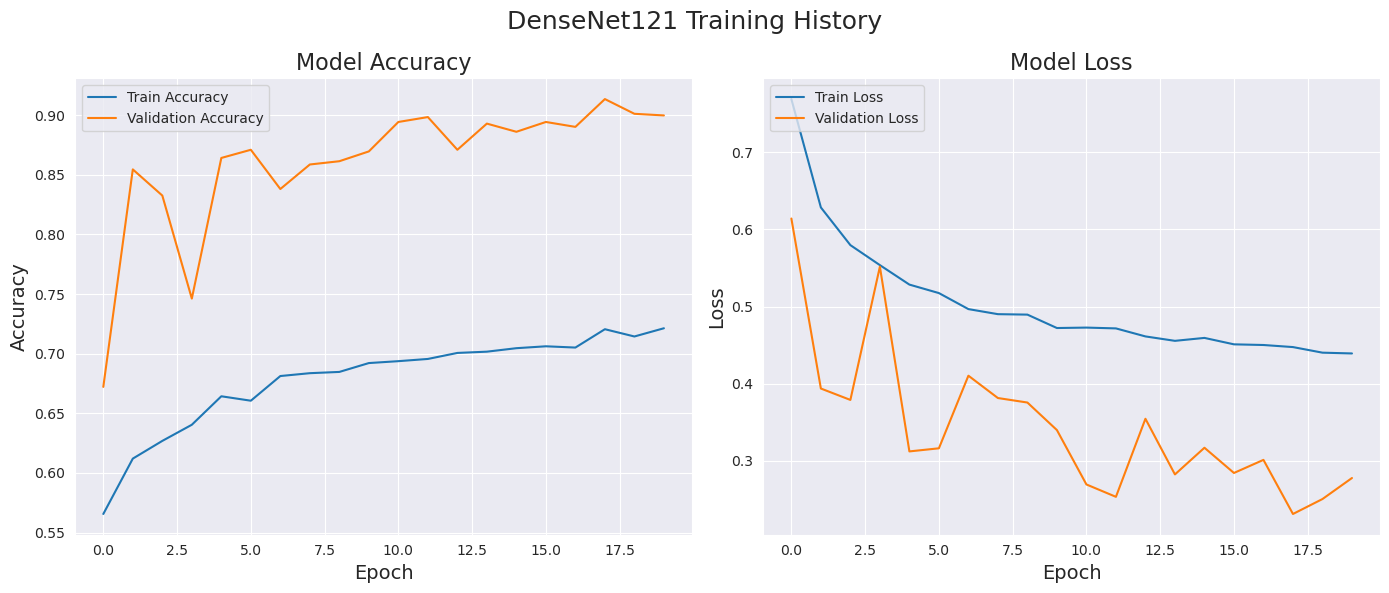

In [16]:
def plot_training_history(history):
	fig, axs = plt.subplots(1, 2, figsize=(14, 6))
	axs[0].plot(history.history['accuracy'], label='Train Accuracy')
	axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
	axs[0].set_title('Model Accuracy', fontsize=16)
	axs[0].set_ylabel('Accuracy', fontsize=14)
	axs[0].set_xlabel('Epoch', fontsize=14)
	axs[0].legend(loc='upper left')
	axs[0].grid(True)

	axs[1].plot(history.history['loss'], label='Train Loss')
	axs[1].plot(history.history['val_loss'], label='Validation Loss')
	axs[1].set_title('Model Loss', fontsize=16)
	axs[1].set_ylabel('Loss', fontsize=14)
	axs[1].set_xlabel('Epoch', fontsize=14)
	axs[1].legend(loc='upper left')
	axs[1].grid(True)

	plt.suptitle('DenseNet121 Training History', fontsize=18)
	plt.tight_layout()
	plt.show()

if os.path.exists('DenseNet121_history.npy'):
	history_data = np.load('DenseNet121_history.npy', allow_pickle=True).item()
	history_n = tf.keras.callbacks.History()
	history_n.history = {
		'loss': history_data['loss'],
		'val_loss': history_data['val_loss'],
		'accuracy': history_data['accuracy'],
		'val_accuracy': history_data['val_accuracy']
	}
plot_training_history(history_n)


--- Evaluating DenseNet121 Model on Test Set ---
Model weights loaded successfully.
Evaluating model on test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 739ms/step - accuracy: 0.9318 - loss: 0.1671
Test Loss: 0.2226
Test Accuracy: 0.9096


2025-07-09 16:31:09.623883: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 744ms/step

=== EVALUATION METRICS ===
Accuracy: 90.9597%
Precision: 98.3707%
Recall: 89.4444%
F1-score: 93.6954%
Matthews correlation coefficient (mcc): 0.7896
ROC AUC: 98.3023%


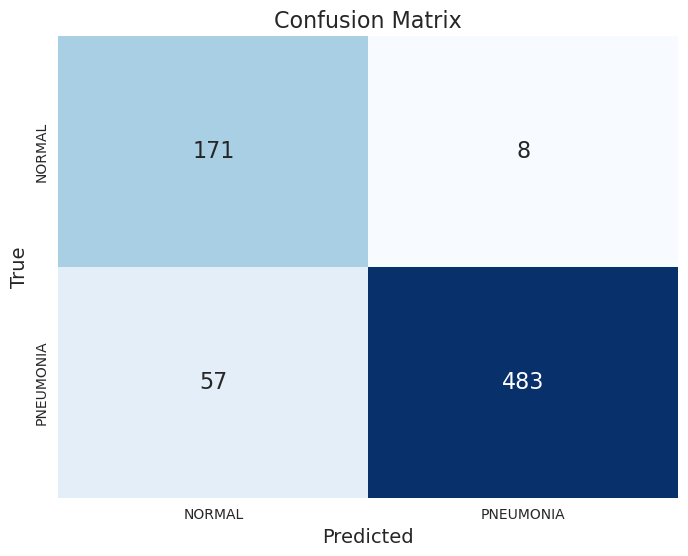

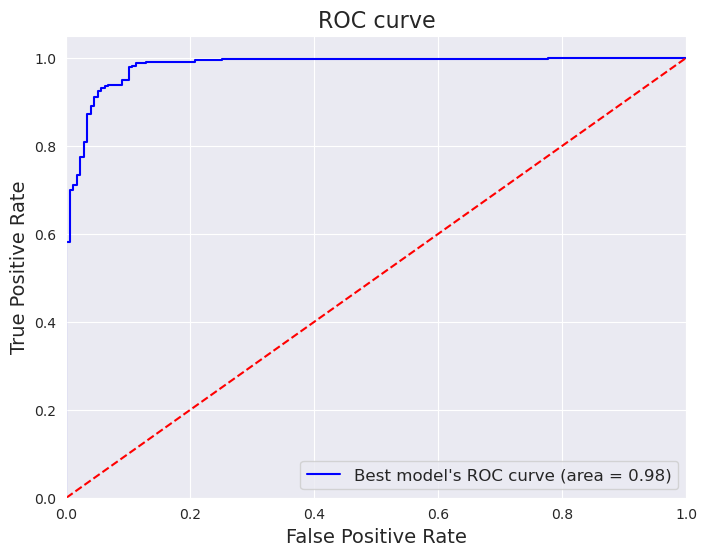

In [19]:
#confusion matrix on test set
def plot_confusion_matrix(y_true, y_pred, classes):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False, annot_kws={"size": 16})
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()
    
def plot_roc_curve(y_true, y_pred):
	fpr, tpr, thresholds = roc_curve(y_true, y_pred)
	roc_auc = auc(fpr, tpr)
	plt.figure(figsize=(8, 6))
	plt.plot(fpr, tpr, color='blue', label=f"Best model's ROC curve (area = {roc_auc:.2f})")
	plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate', fontsize=14)
	plt.ylabel('True Positive Rate', fontsize=14)
	plt.title("ROC curve", fontsize=16)
	plt.legend(loc='lower right', fontsize=12)
	plt.grid(True)
	plt.show()
      
# Evaluate the model on the test set

print("\n--- Evaluating DenseNet121 Model on Test Set ---")
DenseNet_model.load_weights('DenseNet121_best_model.keras')  # Load the best weights
print("Model weights loaded successfully.")
# print model evaluation metrics
print("Evaluating model on test set...")
test_loss, test_accuracy = DenseNet_model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = np.concatenate([y.numpy().flatten() for _, y in test_ds])
y_pred = DenseNet_model.predict(test_ds)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)
mcc = matthews_corrcoef(y_true, y_pred_labels)
roc_auc = roc_auc_score(y_true, y_pred)

# Print evaluation metrics in percentages
print("\n=== EVALUATION METRICS ===")
print(f"Accuracy: {100*accuracy:.4f}%")
print(f"Precision: {100*precision:.4f}%")
print(f"Recall: {100*recall:.4f}%")
print(f"F1-score: {100*f1:.4f}%")
print(f"Matthews correlation coefficient (mcc): {mcc:.4f}")
print(f"ROC AUC: {100*roc_auc:.4f}%")

plot_confusion_matrix(y_true, y_pred_labels, classes=['NORMAL', 'PNEUMONIA'])
plot_roc_curve(y_true, y_pred)


*to do list*
- Restart DenseNet121 training
- Model evaluation and confusion matrix with parameters (try plots and parameters)
- Results comment

### <span style="color: purple;">Xception</span>

# DOMANDE PROF
1. Class imbalance, class weights non funzionano con questo dataset
2. Va bene presentazione con notebook o serve ppt?
3. Più specifico nel descrivere i metodi? Quanto prolisso?